In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

In [2]:
from fastai.text.all import *
path = untar_data(URLs.HUMAN_NUMBERS)

In [3]:
Path.BASE_PATH = path

In [4]:
lines = L()
with open(path/'train.txt') as f: lines += L(*f.readlines())
with open(path/'valid.txt') as f: lines += L(*f.readlines())
lines

(#9998) ['one \n','two \n','three \n','four \n','five \n','six \n','seven \n','eight \n','nine \n','ten \n'...]

### Data Preprocessing
- Preprocess the dataset for the language model
- Manually tokenize and numericalize the data
- Create batches for the model to read

In [5]:
text = " . ".join(line.strip() for line in lines)
text[:50]

'one . two . three . four . five . six . seven . ei'

In [6]:
# get the tokens by splitting on spaces
tokens = text.split()
tokens[:10]

['one', '.', 'two', '.', 'three', '.', 'four', '.', 'five', '.']

In [7]:
vocab = list(set(tokens))
vocab[:10]

['forty',
 'twelve',
 'thirty',
 'four',
 'three',
 'thirteen',
 'seven',
 'seventeen',
 'seventy',
 'two']

In [8]:
word2index = {word: i for i, word in enumerate(vocab)}
word2index['two']

9

In [9]:
num_tokens = [word2index[word] for word in tokens]
num_tokens[:10]

[28, 23, 9, 23, 4, 23, 3, 23, 15, 23]

In [10]:
len_tks = 6

for i in range(0,len_tks-4,3):
  print(i)

0


In [11]:
print(len(tokens))

63095


In [12]:
# want sequences of consecutive characters
seq_len = 16
seqs = [(torch.Tensor(num_tokens[i: i+seq_len]).long(), torch.Tensor(num_tokens[i+1:i+seq_len+1]).long()) for i in range(0,len(num_tokens)-seq_len-1, seq_len)]
seqs[:2]                                                                                         

[(tensor([28, 23,  9, 23,  4, 23,  3, 23, 15, 23, 12, 23,  6, 23, 13, 23]),
  tensor([23,  9, 23,  4, 23,  3, 23, 15, 23, 12, 23,  6, 23, 13, 23, 19])),
 (tensor([19, 23, 24, 23, 25, 23,  1, 23,  5, 23, 29, 23, 22, 23, 14, 23]),
  tensor([23, 24, 23, 25, 23,  1, 23,  5, 23, 29, 23, 22, 23, 14, 23,  7]))]

In [13]:
# want data in order
# (0, m, 2m, ..., )

def group_chunks(dset, bs):
  m = len(dset) // bs
  new_dset = []

  for i in range(m):
    new_dset += [dset[i + m*j] for j in range(bs)]
  return new_dset

In [14]:
bs = 64
cut = int(len(seqs) * 0.8)
dls = DataLoaders.from_dsets(
    group_chunks(seqs[:cut], bs), 
    group_chunks(seqs[cut:], bs), 
    bs=bs, drop_last=True, shuffle=False)

In [15]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 16]), torch.Size([64, 16]))

### Experiment with RNNs
- Write RNNs from scratch

In [40]:
class LMModel1(Module):
  def __init__(self, vocab_sz, n_hidden):
    self.i_h = nn.Embedding(vocab_sz, n_hidden)
    self.h_h = nn.Linear(n_hidden, n_hidden)
    self.h_o = nn.Linear(n_hidden, vocab_sz)
    self.h = 0
    self.relu = nn.ReLU()
  
  def forward(self, x):
    # print(x.shape)
    outs = []
    for i in range(x.shape[1]):
      # add the hidden state to the input to hidden state
      self.h = self.h + self.i_h(x[:, i])
      # compute new hidden state
      self.h = self.relu(self.h_h(self.h))
      # make a prediction for new character
      outs.append(self.h_o(self.h))

      
    self.h = self.h.detach()
    outs = torch.stack(outs, dim=1)
    # print(outs.shape)

    return outs
  
  
  def reset(self):
    self.h = 0

In [41]:
def flat_cross_entropy(inp, targ):
  # flatten the target from (bs, seq) -> (bs*seq)
  # accomodate by flattening inputs (bs, seq, vocab_sz) -> (bs*seq, vocab_sz)
  return F.cross_entropy(inp.view(bs*seq_len, -1), targ.view(-1))

In [42]:
def loss_func(inp, targ):
    return F.cross_entropy(inp.view(-1, len(vocab)), targ.view(-1))

In [43]:
print(len(vocab))

30


SuggestedLRs(valley=0.0008317637839354575)

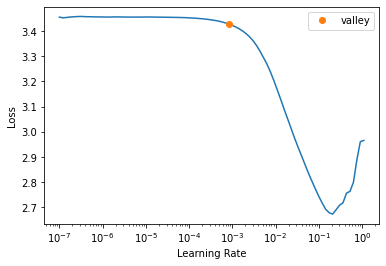

In [44]:
learn = Learner(dls, LMModel1(len(vocab), 64), loss_func=flat_cross_entropy,
                metrics=accuracy, cbs=ModelResetter)
learn.lr_find()

In [45]:
learn.fit_one_cycle(20, 0.0005)

epoch,train_loss,valid_loss,accuracy,time
0,3.423783,3.424371,0.073242,00:01
1,3.312516,3.229440,0.163900,00:01
2,2.970334,2.687676,0.198324,00:01
3,2.308833,1.983862,0.465088,00:01
4,1.845510,1.941948,0.465007,00:01
5,1.616619,1.935381,0.464111,00:01
6,1.486408,1.886540,0.468587,00:01
7,1.402282,1.851322,0.485352,00:01
8,1.341628,1.833439,0.487956,00:01
9,1.292255,1.821207,0.498128,00:01


### Multilayer RNN
- Experiment with multilayer RNNs
- Have a different hidden state in effect making the model deeper (more params to update)
- Make the multilayer RNN from scratch
- Make the multilayer RNN using pytorch

In [46]:
class LMModel2(Module):

  def __init__(self, vocab_sz, n_hidden, n_layers):
    self.i_h = nn.Embedding(vocab_sz, n_hidden)

    self.rnn_layers = []
    # create the middle rnn layers according to n_layers
    for i in range(n_layers):
      self.rnn_layers.append(nn.Linear(n_hidden, n_hidden))
    self.h_o = nn.Linear(n_hidden, vocab_sz)
    self.relu = nn.ReLU()
    self.h = 0

  def forward(self, x):
    outs = []

    # loop through the sequence of inputs
    for i in range(x.shape[1]):
      self.h = self.h + self.i_h(x[:, i])

      # loop through multilayers and apply them
      for layer in self.rnn_layers:
        self.h = self.relu(layer(self.h))
      
      # at the end, go hidden to output
      outs.append(self.h_o(self.h))

    # detach the gradients
    self.h = self.h.detach()

    return torch.stack(outs, dim=1)
  
  def reset(self):
    # reset the hidden state on epoch or validation
    self.h = 0

In [47]:
learn = Learner(dls, LMModel2(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.366212,3.329472,0.099447,00:01
1,3.216942,3.085339,0.101074,00:01
2,2.870018,2.659535,0.112223,00:01
3,2.442954,2.360196,0.136556,00:01
4,2.143498,2.293844,0.140299,00:01
5,1.979220,2.327837,0.125326,00:01
6,1.886826,2.389153,0.200195,00:01
7,1.825766,2.440845,0.285075,00:01
8,1.778096,2.471695,0.297607,00:01
9,1.739628,2.486862,0.305339,00:01
